In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [3]:
# other dependencies
#!pip install timm ipywidgets

In [4]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [5]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [6]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [7]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [8]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob

In [9]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [10]:
!pip install seaborn
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [11]:
#Global Training variables 
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 16
test_batch_size = 16
DEBUG = False
num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [12]:
timm.list_models("conv*", pretrained=True)

['convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [13]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [14]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' , 'others']
classes_no_other = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]
other_ind = classes.index('others')

### Read CSV and get train/test groups

In [15]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [16]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"

    

In [17]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes_no_other:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [18]:
len(df)

6008

In [19]:
USE_SHORT_AUDIO = True

In [20]:
#Test should happen on Cup and Tanzania
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_tz_cup = df[idx_multiclass]

In [21]:
df_tz_cup.reset_index(inplace = True)
df_tz_cup.drop('index',axis = 1)
df.reset_index(inplace = True)
df.drop('index',axis = 1)

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6004,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6005,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6006,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [22]:
#https://stackoverflow.com/questions/18180763/set-difference-for-pandas
df_temp = pd.concat([df, df_tz_cup, df_tz_cup]).drop_duplicates(keep=False)

### Verifying that the temp data does not have any test leakage

In [23]:
#np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_temp[(np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup'))].sum()
#df_temp([df_temp['country'] == 'Tanzania' and df_temp['location_type'] == 'cup'])

<ipython-input-23-96ebbd9acbfe>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_temp[(np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup'))].sum()


index              0.0
id                 0.0
length             0.0
name               0.0
sample_rate        0.0
record_datetime    0.0
sound_type         0.0
species            0.0
gender             0.0
fed                0.0
plurality          0.0
age                0.0
method             0.0
mic_type           0.0
device_type        0.0
country            0.0
district           0.0
province           0.0
place              0.0
location_type      0.0
specie_ind         0.0
dtype: float64

In [24]:
df_temp.reset_index(inplace = True)
df_temp.drop('index',axis = 1,inplace = True)
df_temp.drop('level_0',axis = 1,inplace = True)

In [25]:
df_temp

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3455,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3456,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3457,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [26]:
print("len of df_temp = " + str(len(df_temp)))
print("len of df_tz_cup = " + str(len(df_tz_cup)))
print("len of df = " + str(len(df)))
if (len(df) == len(df_tz_cup) + len(df_temp)):
    print("split successful")
else:
    print("split error")

len of df_temp = 3459
len of df_tz_cup = 2549
len of df = 6008
split successful


### Before we start training we need to also have some samples from tz_cup in training

In [27]:
df_tz_cup_samp = df_tz_cup.sample(frac = .8 , random_state = 42)
print("length of df_tz_cup_samp = " + str(len(df_tz_cup_samp)))

length of df_tz_cup_samp = 2039


In [28]:
df_test = pd.concat([df_tz_cup, df_tz_cup_samp, df_tz_cup_samp]).drop_duplicates(keep=False)

In [29]:
len(df_test)

510

Add some TZ_cup sampled to the Training data

In [30]:
temp_train_frame = [df_temp , df_tz_cup_samp]
df_temp_train = pd.concat(temp_train_frame)
print("length of concatenated frame = " + str(len(df_temp_train)))

length of concatenated frame = 5498


### Finally a train-val split

In [31]:
from sklearn.model_selection import train_test_split

#df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
df_train,df_val  = train_test_split(df_temp_train, test_size=0.2 , random_state= 42)

In [32]:
print("length of train = " + str(len(df_train)))
print("length of val = " + str(len(df_val)))


length of train = 4398
length of val = 1100


In [33]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [34]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 104000
length of test offset = 23294
length of val offset = 24518


In [35]:
# from sklearn.model_selection import train_test_split

# df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# df_train_offset,df_val_offset  = train_test_split(df_train_offset_temp, test_size=0.2)


In [36]:
# for i in range(0,len(classes)):
#     df_temp = df_val_offset[df_val_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))

In [37]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



In [38]:
def get_specie_distri(df , classes , type_df = None):
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [39]:
#class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.3844931  0.80723406 4.37048243 0.81245557 3.46078333 5.12214342
 3.94118539 9.71055089 0.34967033]


In [40]:
len(df_val_offset)

24518

In [41]:
#get_specie_distri(df_train_offset , classes , type_df = "train")
#get_specie_distri(df_val_offset , classes , type_df = "Val")
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
9018
DF type = test
i = 1
4157
DF type = test
i = 2
429
DF type = test
i = 3
3422
DF type = test
i = 4
1327
DF type = test
i = 5
657
DF type = test
i = 6
975
DF type = test
i = 7
423
DF type = test
i = 8
2886


In [42]:
### get the frame offsets for each audio file into dataframes
# audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
# audio_df_test_A = get_offsets_df(df_test_A, short_audio=False)
# audio_df_test_B = get_offsets_df(df_test_B, short_audio=False)

In [43]:
# This function pads a file with 0s to make it a 1.92 sec file
def pad_zero(x_temp,rate = config.rate, min_length = config.min_duration ):
    #print("inside padding zero...")
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    #print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [44]:
def load_model(filepath, model):
    # Instantiate model to inspect
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

In [45]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(0,9))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [46]:
def concat_df(df_offset, indices):
    list_df_ind = []
    #print("len of indices = " + str(len(indices)))
    for ind in indices :
        df_name = "df_"+ str(ind)
        df_name = df_offset[df_offset['specie_ind'] == ind]
        list_df_ind.append(df_name)
    df_offset_trimmed = pd.concat(list_df_ind)
    return(df_offset_trimmed)

In [47]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [48]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [49]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [50]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,222214,0,10.24,8
1,1,222214,2561,10.24,8
2,2,222214,5121,10.24,8
3,3,222214,7681,10.24,8
4,4,222214,10241,10.24,8


In [51]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
    
    
    return test_loss, test_acc , all_y,all_y_pred

In [52]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []
    best_val_loss = np.inf
    best_val_acc = -np.inf
    best_train_acc = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_acc.append(train_acc)
        val_loss, val_acc , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val accuracy = " + str(val_acc))
        all_val_loss.append(val_loss)
        all_val_acc.append(val_acc)
        
        acc_metric = val_acc
        best_acc_metric = best_val_acc
        if acc_metric > best_acc_metric:  
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            print("Now printing classification rport... ")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_acc = val_acc
            best_val_loss = val_loss
            overrun_counter = -1
        overrun_counter += 1
        print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, Val Loss: %.8f, Val Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, val_loss/len(val_loader), val_acc,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [53]:
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_zero(waveform)
        else:
            f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [54]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                          fmin=400, fmax=2000, sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [55]:
# test = torch.rand(1,15360)

# model =Model('convnext_small',224)
# op = model(test)
# print(op)

In [56]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
# from torch.utils.data.sampler import WeightedRandomSampler
# class_sample_count = []
# for i in range(0,len(classes)):
#     df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))
#     class_sample_count.append(len(df_temp))
# print("class_sample_count = " + str(class_sample_count))
# class_sample_count_arr = np.array(class_sample_count)
# weight = 1. / class_sample_count_arr
# print("weight = " +str(weight))
# samples_weight = []
# for t in range(len(classes)):
#     samples_weight.append(weight[t])
    
# samples_weight = np.array(samples_weight)
# print("samples_weight = " +str(samples_weight))

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


In [57]:
df_train_offset

,index,id,offset,length,specie_ind
0,0,222214,0,10.24000,8
1,1,222214,2561,10.24000,8
2,2,222214,5121,10.24000,8
3,3,222214,7681,10.24000,8
4,4,222214,10241,10.24000,8
...,...,...,...,...,...
103995,103995,1130,43521,9.20562,8
103996,103996,1130,46081,9.20562,8
103997,103997,1130,48641,9.20562,8
103998,103998,1130,51201,9.20562,8


In [58]:
train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [59]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 104000
Length of train loader = 6500


In [60]:
# test_iter = iter(val_loader)
# a,b = test_iter.next()
# print(a.shape)
# print(b)

In [61]:
# Test block

#temp_ten = torch.rand(64, 9, 1, 15360)
# temp_ten.shape
# bat_len = temp_ten.shape[0]
# print("bat_len = " +str(bat_len))
# for i in range (bat_len):
#     print("i = " + str(i))
#     elem = temp_ten[i,:,:,:]
#     print("elem shape = " +str(elem.shape))
#     for j in range(elem.shape[0]):
#         img = elem[j,:,:]
#         print("img shape = " +str(img.shape))
        

## Training

In [62]:
len(df_train_offset)

104000

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0813 seconds
Training on cuda:0


  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 0batch = 0 of 6500duraation = 0.011143835385640462
epoch = 0batch = 200 of 6500duraation = 2.6250012079874674
epoch = 0batch = 400 of 6500duraation = 5.249160607655843
epoch = 0batch = 600 of 6500duraation = 7.870618148644765
epoch = 0batch = 800 of 6500duraation = 10.493661590417226
epoch = 0batch = 1000 of 6500duraation = 13.117299552758535
epoch = 0batch = 1200 of 6500duraation = 15.738943556944529
epoch = 0batch = 1400 of 6500duraation = 18.363355902830758
epoch = 0batch = 1600 of 6500duraation = 20.9850421388944
epoch = 0batch = 1800 of 6500duraation = 23.61244072119395
epoch = 0batch = 2000 of 6500duraation = 26.238139156500498
epoch = 0batch = 2200 of 6500duraation = 28.863558928171795
epoch = 0batch = 2400 of 6500duraation = 31.488798213005065
epoch = 0batch = 2600 of 6500duraation = 34.11381036440532
epoch = 0batch = 2800 of 6500duraation = 36.738055968284606
epoch = 0batch = 3000 of 6500duraation = 39.3658860206604
epoch = 0batch = 3200 of 6500duraation = 41.991337954

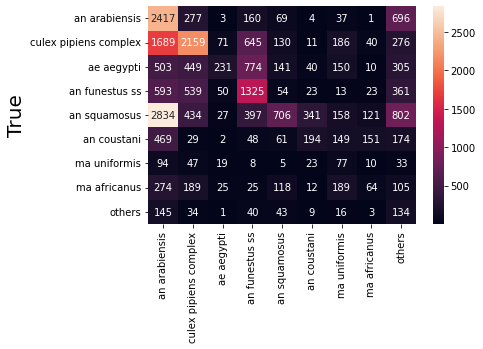

Epoch: 0, Train Loss: 1.56620664, Train Acc: 0.45343269, Val Loss: 0.00087638, Val Acc: 0.51810914, overrun_counter 0


  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 1batch = 0 of 6500duraation = 0.011305034160614014
epoch = 1batch = 200 of 6500duraation = 2.6382968346277873
epoch = 1batch = 400 of 6500duraation = 5.259860237439473
epoch = 1batch = 600 of 6500duraation = 7.882692937056223
epoch = 1batch = 800 of 6500duraation = 10.505304976304371
epoch = 1batch = 1000 of 6500duraation = 13.129727296034496
epoch = 1batch = 1200 of 6500duraation = 15.754888395468393
epoch = 1batch = 1400 of 6500duraation = 18.37800567150116
epoch = 1batch = 1600 of 6500duraation = 21.002668913205465
epoch = 1batch = 1800 of 6500duraation = 23.62698891162872
epoch = 1batch = 2000 of 6500duraation = 26.24968607823054
epoch = 1batch = 2200 of 6500duraation = 28.879637563228606
epoch = 1batch = 2400 of 6500duraation = 31.502848796049754
epoch = 1batch = 2600 of 6500duraation = 34.12831431229909
epoch = 1batch = 2800 of 6500duraation = 36.755642116069794
epoch = 1batch = 3000 of 6500duraation = 39.38130450248718
epoch = 1batch = 3200 of 6500duraation = 42.00957705

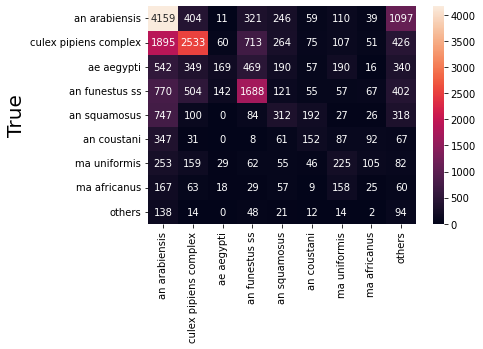

Epoch: 1, Train Loss: 0.95188357, Train Acc: 0.65775000, Val Loss: 0.00075207, Val Acc: 0.60547353, overrun_counter 0


  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 2batch = 0 of 6500duraation = 0.010041904449462891
epoch = 2batch = 200 of 6500duraation = 2.63548139333725
epoch = 2batch = 400 of 6500duraation = 5.254828250408172
epoch = 2batch = 600 of 6500duraation = 7.880626706282298
epoch = 2batch = 800 of 6500duraation = 10.506472833951314
epoch = 2batch = 1000 of 6500duraation = 13.129983941713968
epoch = 2batch = 1200 of 6500duraation = 15.756163879235585
epoch = 2batch = 1400 of 6500duraation = 18.37913697163264
epoch = 2batch = 1600 of 6500duraation = 21.003052826722463
epoch = 2batch = 1800 of 6500duraation = 23.62594490845998
epoch = 2batch = 2000 of 6500duraation = 26.249556509653726
epoch = 2batch = 2200 of 6500duraation = 28.875330273310343
epoch = 2batch = 2400 of 6500duraation = 31.50083421866099
epoch = 2batch = 2600 of 6500duraation = 34.127486463387804
epoch = 2batch = 2800 of 6500duraation = 36.75325777133306
epoch = 2batch = 3000 of 6500duraation = 39.37980170647303
epoch = 2batch = 3200 of 6500duraation = 42.0077019929

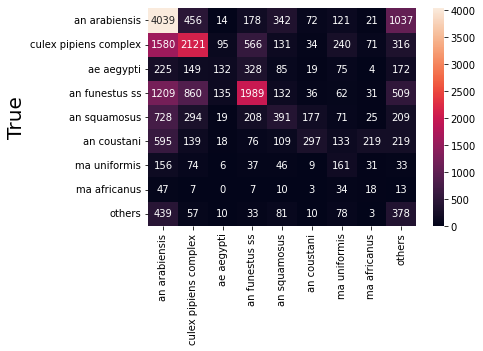

Epoch: 2, Train Loss: 0.67491691, Train Acc: 0.74096154, Val Loss: 0.00080582, Val Acc: 0.61273350, overrun_counter 0


  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 3batch = 0 of 6500duraation = 0.009606889883677165
epoch = 3batch = 200 of 6500duraation = 2.636281438668569
epoch = 3batch = 400 of 6500duraation = 5.260192318757375
epoch = 3batch = 600 of 6500duraation = 7.884634705384572
epoch = 3batch = 800 of 6500duraation = 10.5100679397583
epoch = 3batch = 1000 of 6500duraation = 13.13435693581899
epoch = 3batch = 1200 of 6500duraation = 15.763802357514699
epoch = 3batch = 1400 of 6500duraation = 18.3860333998998
epoch = 3batch = 1600 of 6500duraation = 21.01100372870763
epoch = 3batch = 1800 of 6500duraation = 23.637753669420878
epoch = 3batch = 2000 of 6500duraation = 26.262360660235085
epoch = 3batch = 2200 of 6500duraation = 28.888041830062868
epoch = 3batch = 2400 of 6500duraation = 31.51320963303248
epoch = 3batch = 2600 of 6500duraation = 34.140157759189606
epoch = 3batch = 2800 of 6500duraation = 36.768256747722624
epoch = 3batch = 3000 of 6500duraation = 39.39356382290522
epoch = 3batch = 3200 of 6500duraation = 42.017868657906

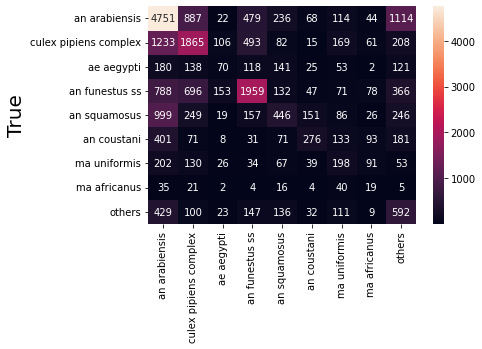

Epoch: 3, Train Loss: 0.50477763, Train Acc: 0.80463462, Val Loss: 0.00087208, Val Acc: 0.63149523, overrun_counter 0


  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 4batch = 0 of 6500duraation = 0.009021552403767903
epoch = 4batch = 200 of 6500duraation = 2.634534748395284
epoch = 4batch = 400 of 6500duraation = 5.254855128129323
epoch = 4batch = 600 of 6500duraation = 7.879711854457855
epoch = 4batch = 800 of 6500duraation = 10.504486159483593
epoch = 4batch = 1000 of 6500duraation = 13.129596980412801
epoch = 4batch = 1200 of 6500duraation = 15.756388755639394
epoch = 4batch = 1400 of 6500duraation = 18.378475280602775
epoch = 4batch = 1600 of 6500duraation = 21.005314461390178
epoch = 4batch = 1800 of 6500duraation = 23.630021131038667
epoch = 4batch = 2000 of 6500duraation = 26.256028858820596
epoch = 4batch = 2200 of 6500duraation = 28.88203830718994
epoch = 4batch = 2400 of 6500duraation = 31.507507181167604
epoch = 4batch = 2600 of 6500duraation = 34.136029454072315
epoch = 4batch = 2800 of 6500duraation = 36.761017219225565
epoch = 4batch = 3000 of 6500duraation = 39.3871216972669
epoch = 4batch = 3200 of 6500duraation = 42.0097597

  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 5batch = 0 of 6500duraation = 0.010187685489654541
epoch = 5batch = 200 of 6500duraation = 2.637173354625702
epoch = 5batch = 400 of 6500duraation = 5.259363957246145
epoch = 5batch = 600 of 6500duraation = 7.883662056922913
epoch = 5batch = 800 of 6500duraation = 10.506738193829854
epoch = 5batch = 1000 of 6500duraation = 13.131835234165191
epoch = 5batch = 1200 of 6500duraation = 15.757542101542155
epoch = 5batch = 1400 of 6500duraation = 18.38220065832138
epoch = 5batch = 1600 of 6500duraation = 21.006934010982512
epoch = 5batch = 1800 of 6500duraation = 23.63278075059255
epoch = 5batch = 2000 of 6500duraation = 26.260226126511892
epoch = 5batch = 2200 of 6500duraation = 28.88734787305196
epoch = 5batch = 2400 of 6500duraation = 31.512200884024303
epoch = 5batch = 2600 of 6500duraation = 34.136270785331725
epoch = 5batch = 2800 of 6500duraation = 36.76262294451396
epoch = 5batch = 3000 of 6500duraation = 39.388385911782585
epoch = 5batch = 3200 of 6500duraation = 42.01826103

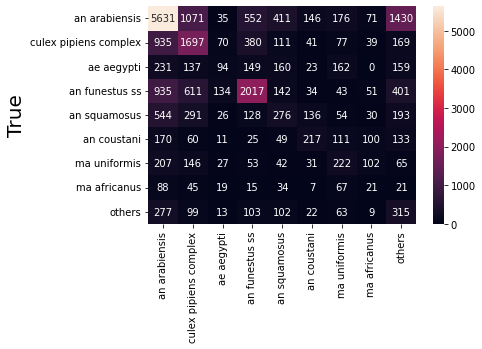

Epoch: 5, Train Loss: 0.33496606, Train Acc: 0.87062500, Val Loss: 0.00097107, Val Acc: 0.64059059, overrun_counter 0


  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 6batch = 0 of 6500duraation = 0.00880205233891805
epoch = 6batch = 200 of 6500duraation = 2.635637307167053
epoch = 6batch = 400 of 6500duraation = 5.258258720239003
epoch = 6batch = 600 of 6500duraation = 7.8840063889821375
epoch = 6batch = 800 of 6500duraation = 10.50822145541509
epoch = 6batch = 1000 of 6500duraation = 13.132505480448405
epoch = 6batch = 1200 of 6500duraation = 15.758414022127788
epoch = 6batch = 1400 of 6500duraation = 18.381787991523744
epoch = 6batch = 1600 of 6500duraation = 21.00721034606298
epoch = 6batch = 1800 of 6500duraation = 23.63270870447159
epoch = 6batch = 2000 of 6500duraation = 26.256197754542033
epoch = 6batch = 2200 of 6500duraation = 28.882316263516746
epoch = 6batch = 2400 of 6500duraation = 31.505814901987712
epoch = 6batch = 2600 of 6500duraation = 34.13174870411555
epoch = 6batch = 2800 of 6500duraation = 36.75896526575089
epoch = 6batch = 3000 of 6500duraation = 39.38126232624054
epoch = 6batch = 3200 of 6500duraation = 42.0075745662

  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 7batch = 0 of 6500duraation = 0.011532127857208252
epoch = 7batch = 200 of 6500duraation = 2.637681225935618
epoch = 7batch = 400 of 6500duraation = 5.2640511155128475
epoch = 7batch = 600 of 6500duraation = 7.889372630914052
epoch = 7batch = 800 of 6500duraation = 10.515742897987366
epoch = 7batch = 1000 of 6500duraation = 13.141592419147491
epoch = 7batch = 1200 of 6500duraation = 15.764426108201345
epoch = 7batch = 1400 of 6500duraation = 18.38906096617381
epoch = 7batch = 1600 of 6500duraation = 21.017607990900675
epoch = 7batch = 1800 of 6500duraation = 23.640841829776765
epoch = 7batch = 2000 of 6500duraation = 26.2680233001709
epoch = 7batch = 2200 of 6500duraation = 28.894660047690074
epoch = 7batch = 2400 of 6500duraation = 31.521553214391073
epoch = 7batch = 2600 of 6500duraation = 34.14803276062012
epoch = 7batch = 2800 of 6500duraation = 36.77412656943003
epoch = 7batch = 3000 of 6500duraation = 39.40471684932709
epoch = 7batch = 3200 of 6500duraation = 42.032990304

  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 8batch = 0 of 6500duraation = 0.011476087570190429
epoch = 8batch = 200 of 6500duraation = 2.6364428639411925
epoch = 8batch = 400 of 6500duraation = 5.260793574651083
epoch = 8batch = 600 of 6500duraation = 7.884049983819326
epoch = 8batch = 800 of 6500duraation = 10.508489235242207
epoch = 8batch = 1000 of 6500duraation = 13.132601261138916
epoch = 8batch = 1200 of 6500duraation = 15.756445050239563
epoch = 8batch = 1400 of 6500duraation = 18.38538188536962
epoch = 8batch = 1600 of 6500duraation = 21.010575580596925
epoch = 8batch = 1800 of 6500duraation = 23.63478257258733
epoch = 8batch = 2000 of 6500duraation = 26.26319807767868
epoch = 8batch = 2200 of 6500duraation = 28.88642113208771
epoch = 8batch = 2400 of 6500duraation = 31.513858417669933
epoch = 8batch = 2600 of 6500duraation = 34.14141898552577
epoch = 8batch = 2800 of 6500duraation = 36.76760324239731
epoch = 8batch = 3000 of 6500duraation = 39.39706814686458
epoch = 8batch = 3200 of 6500duraation = 42.0260511438

  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 9batch = 0 of 6500duraation = 0.010694066683451334
epoch = 9batch = 200 of 6500duraation = 2.6350670218467713
epoch = 9batch = 400 of 6500duraation = 5.2576718131701154
epoch = 9batch = 600 of 6500duraation = 7.881121671199798
epoch = 9batch = 800 of 6500duraation = 10.508166488011678
epoch = 9batch = 1000 of 6500duraation = 13.132535628477733
epoch = 9batch = 1200 of 6500duraation = 15.75805819829305
epoch = 9batch = 1400 of 6500duraation = 18.38471530278524
epoch = 9batch = 1600 of 6500duraation = 21.009539663791656
epoch = 9batch = 1800 of 6500duraation = 23.63645390669505
epoch = 9batch = 2000 of 6500duraation = 26.261686380704244
epoch = 9batch = 2200 of 6500duraation = 28.88755901257197
epoch = 9batch = 2400 of 6500duraation = 31.51441511710485
epoch = 9batch = 2600 of 6500duraation = 34.141193902492525
epoch = 9batch = 2800 of 6500duraation = 36.76746582984924
epoch = 9batch = 3000 of 6500duraation = 39.395485031604764
epoch = 9batch = 3200 of 6500duraation = 42.02015906

  0%|          | 0/6500 [00:00<?, ?it/s]

epoch = 10batch = 0 of 6500duraation = 0.011498932043711345
epoch = 10batch = 200 of 6500duraation = 2.6367425203323362
epoch = 10batch = 400 of 6500duraation = 5.261361332734426
epoch = 10batch = 600 of 6500duraation = 7.882420535882314
epoch = 10batch = 800 of 6500duraation = 10.508843036492665
epoch = 10batch = 1000 of 6500duraation = 13.1319340467453
epoch = 10batch = 1200 of 6500duraation = 15.75863320827484
epoch = 10batch = 1400 of 6500duraation = 18.38437116543452
epoch = 10batch = 1600 of 6500duraation = 21.011174845695496
epoch = 10batch = 1800 of 6500duraation = 23.637119483947753
epoch = 10batch = 2000 of 6500duraation = 26.26396949291229
epoch = 10batch = 2200 of 6500duraation = 28.88979706366857
epoch = 10batch = 2400 of 6500duraation = 31.515391488869984
epoch = 10batch = 2600 of 6500duraation = 34.14224384228388
epoch = 10batch = 2800 of 6500duraation = 36.76954505840937
epoch = 10batch = 3000 of 6500duraation = 39.39913567701976
epoch = 10batch = 3200 of 6500duraation 

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [63]:
model =Model('convnext_xlarge_384_in22ft1k',384)
#train_loader, val_loader, model = None,  classes = classes,n_channels = 1
model, lr_log = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))